## Task 

Machine Learning experiment to predict the rating of a review on a scale from 1- 5 based only on the text of the review.

Importing Libraries

In [1]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.stem import PorterStemmer
import spacy
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
warnings.filterwarnings('ignore')
from sklearn.svm import SVC
from sklearn.metrics import  accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


### Loading Dataset and data visualization

In [2]:
pd.set_option('display.max_colwidth', 200)
restaurant_review_df =  pd.read_csv('restaurant-reviews.csv')
restaurant_review_df.head(3)

,name,restaurant_url,title,text,rating
0,Manufactur,https://www.tripadvisor.com/Restaurant_Review-g187412-d8410818-Reviews-Manufactur-Kiel_Schleswig_Holstein.html,Best in Kiel,"The absolutely best restaurant in the town of Kiel! Nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - I can really recomand their fish...",5.0
1,Manufactur,https://www.tripadvisor.com/Restaurant_Review-g187412-d8410818-Reviews-Manufactur-Kiel_Schleswig_Holstein.html,"Simply, tasty and very good",Tasty and high quality food! A “healthier”way to propose comfort food. The guys are kind and helpful. Bear in mind: cash only payment so far,5.0
2,Manufactur,https://www.tripadvisor.com/Restaurant_Review-g187412-d8410818-Reviews-Manufactur-Kiel_Schleswig_Holstein.html,Delicious fast food!,The food was more than we asked for and we where happily surprised by the food in the small restaurant. The food was very affordable for a family and tasted delicious! It was also fast and friendl...,5.0


### IDA

In [3]:
#finding shape of dataset
print(f"Number of rows in dataset: {restaurant_review_df.shape[0]}")
print(f"Number of cols in dataset: {restaurant_review_df.shape[1]}")

#checking null values
null_values = restaurant_review_df.isnull().sum()
print(f'Null values are: \n{null_values}')

#observation: no null values present in our dataset

Number of rows in dataset: 1000
Number of cols in dataset: 5
Null values are: 
name              0
restaurant_url    0
title             0
text              0
rating            0
dtype: int64


In [4]:
# prediction of rating on the basis of text of review, thus using only text and rating column
restaurant_review_df_cpy = restaurant_review_df.copy()
restaurant_review_df_cpy['final_text'] = restaurant_review_df_cpy['title'].astype(str) + ' ' + restaurant_review_df_cpy['text'].astype(str)
restaurant_review_df_cpy = restaurant_review_df_cpy[['final_text', 'rating']]
restaurant_review_df_cpy.head(2)


,final_text,rating
0,"Best in Kiel The absolutely best restaurant in the town of Kiel! Nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - I can really recoma...",5.0
1,"Simply, tasty and very good Tasty and high quality food! A “healthier”way to propose comfort food. The guys are kind and helpful. Bear in mind: cash only payment so far",5.0


In [5]:
# visualizing 
rating_grp_count = restaurant_review_df_cpy.groupby('rating').count() 
rating_grp_count

,final_text
rating,
1.0,40
2.0,54
3.0,104
4.0,333
5.0,469


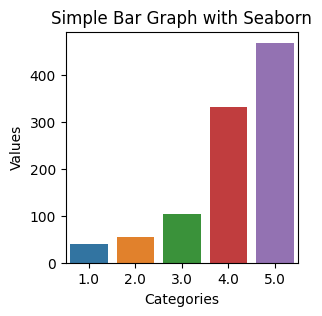

In [6]:
#Bar graph plotting
plt.figure(figsize=(3,3))
sns.barplot(x=rating_grp_count.index, y=rating_grp_count['final_text'])

# Add labels and title using matplotlib
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Simple Bar Graph with Seaborn')

# Display the plot
plt.show()

We can observe that there is large number of classes for rating of 5 as compared to rating of 1, which results in class imbalance. Thus we need to handle this case for proper prediction. Therefore, we will use Random oversampling method to generate the minority classes samples. We will apply random oversampling after feature engineering method.

## Exercise 1

Systematic analysis of the effectiveness of different text preprocessing techniques

### Text Preprocessing Methods Analysis

Lowercasing

In [7]:
# applying lower case for text consistency 
restaurant_review_df_cpy.loc[:,'lower_cased'] = restaurant_review_df_cpy['final_text'].apply(lambda x : x.lower())
restaurant_review_df_cpy.head(2)

,final_text,rating,lower_cased
0,"Best in Kiel The absolutely best restaurant in the town of Kiel! Nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - I can really recoma...",5.0,"best in kiel the absolutely best restaurant in the town of kiel! nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - i can really recoma..."
1,"Simply, tasty and very good Tasty and high quality food! A “healthier”way to propose comfort food. The guys are kind and helpful. Bear in mind: cash only payment so far",5.0,"simply, tasty and very good tasty and high quality food! a “healthier”way to propose comfort food. the guys are kind and helpful. bear in mind: cash only payment so far"


Cleaning Dataset by removing Punctuation Marks

In [8]:
def clean_data(text):
    # some punctuations which can convey emptions
    retention_list = ['!', '?'] 

    pattern_punc = r"[^\w\s" + re.escape(''.join(retention_list)) + r"]"

    #removing punctuation
    result =  re.sub(pattern_punc, '', text)

    #removing unnnecessary space
    result = re.sub(r'\s+', ' ', result)

    #expanding contractions
    result = contractions.fix(result)

    #removing html tags 
    result = re.sub(r'<.*?>', '', result)

    return result.strip()


restaurant_review_df_cpy.loc[:,"clean_text"] = restaurant_review_df_cpy['lower_cased'].apply(clean_data)
restaurant_review_df_cpy.head(2)

,final_text,rating,lower_cased,clean_text
0,"Best in Kiel The absolutely best restaurant in the town of Kiel! Nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - I can really recoma...",5.0,"best in kiel the absolutely best restaurant in the town of kiel! nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - i can really recoma...",best in kiel the absolutely best restaurant in the town of kiel! nice decor good space super charming backyard with possibility to dine outdoor great service fresh food i can really recomand their...
1,"Simply, tasty and very good Tasty and high quality food! A “healthier”way to propose comfort food. The guys are kind and helpful. Bear in mind: cash only payment so far",5.0,"simply, tasty and very good tasty and high quality food! a “healthier”way to propose comfort food. the guys are kind and helpful. bear in mind: cash only payment so far",simply tasty and very good tasty and high quality food! a healthierway to propose comfort food the guys are kind and helpful bear in mind cash only payment so far


Finding out stop words from our document which are not relevant for analysis of review

In [10]:
#using nlp to detect adjective and verbs
nlp = spacy.load('en_core_web_md')

restaurant_review_df_cpy["doc"] = list(nlp.pipe(restaurant_review_df_cpy['lower_cased']))

restaurant_review_df_cpy["entites"] = restaurant_review_df_cpy['doc'].apply(lambda x: [entity.text for entity in x.ents if entity.label_ == "PERSON" or entity.label_ == "ORG" or entity.label_ == "GPE" ])

restaurant_review_df_cpy['entites'].values
entities = set()

for i in restaurant_review_df_cpy['entites']:
    for j in i: 
        entities.add(j)

Tokenization and Stop words Removal

In [11]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english')) 
    en_words = set(nltk.corpus.words.words())
   
#    #updating stop words
#     stop_words.update(['restaurant', 'food', 'service', 'experience', "pizza", "burger", "sushi","beef","drinks","meat","pasta","cheese","steak", "beer"
#                         "italian", "mexican", "asian","kiel","germany","hamburg", "dish", "menu", "place","town", "cheeseburger"])
    stop_words.update(entities)

    tokens = word_tokenize(text)

    filtered_words = [token for token in tokens if token not in stop_words and token.isalpha()] 

    filtered_words = [w for w in filtered_words if w in en_words]

    return ' '.join(filtered_words) 

restaurant_review_df_cpy.loc[:,'stop_words_removed'] = restaurant_review_df_cpy['lower_cased'].apply(remove_stopwords)
restaurant_review_df_cpy.head(2)


,final_text,rating,lower_cased,clean_text,doc,entites,stop_words_removed
0,"Best in Kiel The absolutely best restaurant in the town of Kiel! Nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - I can really recoma...",5.0,"best in kiel the absolutely best restaurant in the town of kiel! nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - i can really recoma...",best in kiel the absolutely best restaurant in the town of kiel! nice decor good space super charming backyard with possibility to dine outdoor great service fresh food i can really recomand their...,"(best, in, kiel, the, absolutely, best, restaurant, in, the, town, of, kiel, !, nice, decor, ,, good, space, ,, super, charming, back, -, yard, ,, with, possibility, to, dine, outdoor, ,, great, s...",[kiel],best absolutely best restaurant town nice good space super charming possibility dine outdoor great service fresh food really fish absolutely delicious mention best friendly staff next time back
1,"Simply, tasty and very good Tasty and high quality food! A “healthier”way to propose comfort food. The guys are kind and helpful. Bear in mind: cash only payment so far",5.0,"simply, tasty and very good tasty and high quality food! a “healthier”way to propose comfort food. the guys are kind and helpful. bear in mind: cash only payment so far",simply tasty and very good tasty and high quality food! a healthierway to propose comfort food the guys are kind and helpful bear in mind cash only payment so far,"(simply, ,, tasty, and, very, good, tasty, and, high, quality, food, !, a, “, healthier”way, to, propose, comfort, food, ., the, guys, are, kind, and, helpful, ., bear, in, mind, :, cash, only, pa...",[],simply tasty good tasty high quality food way propose comfort food kind helpful bear mind cash payment far


Lemmatization

In [12]:
def lemmatize_text(text):
    lemmatized_text = ' '.join([token.lemma_ for token in text])
    return lemmatized_text

restaurant_review_df_cpy['lemmatized_text'] = restaurant_review_df_cpy['doc'].apply(lemmatize_text)
restaurant_review_df_cpy.head(2)

,final_text,rating,lower_cased,clean_text,doc,entites,stop_words_removed,lemmatized_text
0,"Best in Kiel The absolutely best restaurant in the town of Kiel! Nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - I can really recoma...",5.0,"best in kiel the absolutely best restaurant in the town of kiel! nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - i can really recoma...",best in kiel the absolutely best restaurant in the town of kiel! nice decor good space super charming backyard with possibility to dine outdoor great service fresh food i can really recomand their...,"(best, in, kiel, the, absolutely, best, restaurant, in, the, town, of, kiel, !, nice, decor, ,, good, space, ,, super, charming, back, -, yard, ,, with, possibility, to, dine, outdoor, ,, great, s...",[kiel],best absolutely best restaurant town nice good space super charming possibility dine outdoor great service fresh food really fish absolutely delicious mention best friendly staff next time back,"well in kiel the absolutely good restaurant in the town of kiel ! nice decor , good space , super charming back - yard , with possibility to dine outdoor , great service , fresh food - I can reall..."
1,"Simply, tasty and very good Tasty and high quality food! A “healthier”way to propose comfort food. The guys are kind and helpful. Bear in mind: cash only payment so far",5.0,"simply, tasty and very good tasty and high quality food! a “healthier”way to propose comfort food. the guys are kind and helpful. bear in mind: cash only payment so far",simply tasty and very good tasty and high quality food! a healthierway to propose comfort food the guys are kind and helpful bear in mind cash only payment so far,"(simply, ,, tasty, and, very, good, tasty, and, high, quality, food, !, a, “, healthier”way, to, propose, comfort, food, ., the, guys, are, kind, and, helpful, ., bear, in, mind, :, cash, only, pa...",[],simply tasty good tasty high quality food way propose comfort food kind helpful bear mind cash payment far,"simply , tasty and very good tasty and high quality food ! a "" healthier”way to propose comfort food . the guy be kind and helpful . bear in mind : cash only payment so far"


Stemming

In [13]:
# Provide an example sentence that highlights the differences between the three stemmers (Porter, Snowball, Lancaster)
def stemming(text):
    tokens = word_tokenize(text)
    filtered_words = [PorterStemmer().stem(token) for token in tokens]
    return ' '.join(filtered_words) 

restaurant_review_df_cpy['stemmed_text'] = restaurant_review_df_cpy['lower_cased'].apply(stemming)
restaurant_review_df_cpy.head(2)

,final_text,rating,lower_cased,clean_text,doc,entites,stop_words_removed,lemmatized_text,stemmed_text
0,"Best in Kiel The absolutely best restaurant in the town of Kiel! Nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - I can really recoma...",5.0,"best in kiel the absolutely best restaurant in the town of kiel! nice decor, good space, super charming back-yard, with possibility to dine outdoor, great service, fresh food - i can really recoma...",best in kiel the absolutely best restaurant in the town of kiel! nice decor good space super charming backyard with possibility to dine outdoor great service fresh food i can really recomand their...,"(best, in, kiel, the, absolutely, best, restaurant, in, the, town, of, kiel, !, nice, decor, ,, good, space, ,, super, charming, back, -, yard, ,, with, possibility, to, dine, outdoor, ,, great, s...",[kiel],best absolutely best restaurant town nice good space super charming possibility dine outdoor great service fresh food really fish absolutely delicious mention best friendly staff next time back,"well in kiel the absolutely good restaurant in the town of kiel ! nice decor , good space , super charming back - yard , with possibility to dine outdoor , great service , fresh food - I can reall...","best in kiel the absolut best restaur in the town of kiel ! nice decor , good space , super charm back-yard , with possibl to dine outdoor , great servic , fresh food - i can realli recomand their..."
1,"Simply, tasty and very good Tasty and high quality food! A “healthier”way to propose comfort food. The guys are kind and helpful. Bear in mind: cash only payment so far",5.0,"simply, tasty and very good tasty and high quality food! a “healthier”way to propose comfort food. the guys are kind and helpful. bear in mind: cash only payment so far",simply tasty and very good tasty and high quality food! a healthierway to propose comfort food the guys are kind and helpful bear in mind cash only payment so far,"(simply, ,, tasty, and, very, good, tasty, and, high, quality, food, !, a, “, healthier”way, to, propose, comfort, food, ., the, guys, are, kind, and, helpful, ., bear, in, mind, :, cash, only, pa...",[],simply tasty good tasty high quality food way propose comfort food kind helpful bear mind cash payment far,"simply , tasty and very good tasty and high quality food ! a "" healthier”way to propose comfort food . the guy be kind and helpful . bear in mind : cash only payment so far","simpli , tasti and veri good tasti and high qualiti food ! a “ healthier ” way to propos comfort food . the guy are kind and help . bear in mind : cash onli payment so far"


Here we have done the various methods of text preprocessing, we will move forward to apply this in ML Algo and check which method or combination of suits best with highest accuracy score.

### Testing Model on different Text preprocessing Methods

In [14]:
#data splitting
def splitting_text_preprocessing(X,y, name_of_preprocessing, stratify):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=stratify)
    return   X_train, X_test, y_train, y_test, name_of_preprocessing

### Feature Engineering Methods

In [15]:
def bag_of_words(X_train, X_test): 
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, vectorizer

def tf_idf(X_train, X_test):
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, vectorizer

#Taking two consecutive words
def bag_of_2grams(X_train, X_test):
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, vectorizer


### Baseline Model

In [16]:
#Random Forest Classifier
def baseline_model(X_train, X_test, y_train): 
    clf = RandomForestClassifier(n_estimators=1000, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return y_pred

### Model Evalutation

In [17]:
df_evalutation = pd.DataFrame()
def eval(y_true, y_pred, name_of_preprocessing, df_evalutation):
    df_evalutation = pd.concat([df_evalutation, pd.DataFrame([{
        'text_preprocessing_method': name_of_preprocessing,
        'accuracy': accuracy_score(y_true, y_pred),
        'precision_macro': precision_score(y_true, y_pred, average='macro'),
        'recall_macro': recall_score(y_true, y_pred, average='macro'),
        'f1_macro': f1_score(y_true, y_pred, average='macro'),
        'balanced_accuracy': balanced_accuracy_score(y_true, y_pred)
    }]) ], ignore_index=True)
   
    return df_evalutation

Cleaned Text Analysis

In [19]:
# testing with only clean text 
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing( X=restaurant_review_df_cpy['clean_text'],y=restaurant_review_df_cpy['rating'], 
                                                                                       name_of_preprocessing= 'cleaned_text_only' ,stratify=restaurant_review_df_cpy['rating'])

#applying bag of words
X_train, X_test, bag_of_words_vectorizer = bag_of_words(X_train= X_train, X_test= X_test)

#oversampling 
ros = RandomOverSampler(random_state=0)

# resampled training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#applying model
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)

#Evaluating model
df_evalutation = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_evalutation)
df_evalutation

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,cleaned_text_only,0.625,0.77434,0.393806,0.436889,0.393806


No Cleaning and using Stop Words removal text analysis

In [20]:
# testing with stop words removal
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing( X=restaurant_review_df_cpy['stop_words_removed'],y=restaurant_review_df_cpy['rating'],
                                                                                       name_of_preprocessing= 'stop_word_removal_only' ,stratify=restaurant_review_df_cpy['rating'])

#applying bag of words
X_train, X_test, bag_of_words_vectorizer  = bag_of_words(X_train= X_train, X_test= X_test)

#oversampling 
ros = RandomOverSampler(random_state=0)

# resampled training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#applying model
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)

#Evaluating model
df_evalutation = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_evalutation)
df_evalutation

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,cleaned_text_only,0.625,0.774340,0.393806,0.436889,0.393806
1,stop_word_removal_only,0.655,0.794137,0.500444,0.539084,0.500444


No Cleaning and using Stemming text analysis

In [21]:
# testing with stemmed text
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing(X= restaurant_review_df_cpy['stemmed_text'],y=restaurant_review_df_cpy['rating'],
                                                                                      name_of_preprocessing= 'stemmed_text_only' ,stratify=restaurant_review_df_cpy['rating'] )

#applying bag of words
X_train, X_test, bag_of_words_vectorizer  = bag_of_words(X_train= X_train, X_test= X_test)

#oversampling 
ros = RandomOverSampler(random_state=0)

# resampled training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#applying model
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)

#Evaluating model
df_evalutation = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_evalutation)
df_evalutation

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,cleaned_text_only,0.625,0.774340,0.393806,0.436889,0.393806
1,stop_word_removal_only,0.655,0.794137,0.500444,0.539084,0.500444
2,stemmed_text_only,0.635,0.777619,0.398061,0.440592,0.398061


No Cleaning and using Lemmatization text analysis

In [23]:
# testing with lemmatized text
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing(X= restaurant_review_df_cpy['lemmatized_text'],y=restaurant_review_df_cpy['rating'], 
                                                                                      name_of_preprocessing= 'lemmatized_text_only' ,stratify=restaurant_review_df_cpy['rating'])

#applying bag of words
X_train, X_test, bag_of_words_vectorizer  = bag_of_words(X_train= X_train, X_test= X_test)

#oversampling 
ros = RandomOverSampler(random_state=0)

# resampled training data
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

#applying model
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)

#Evaluating model
df_evalutation = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_evalutation)
df_evalutation

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,cleaned_text_only,0.625,0.774340,0.393806,0.436889,0.393806
1,stop_word_removal_only,0.655,0.794137,0.500444,0.539084,0.500444
2,stemmed_text_only,0.635,0.777619,0.398061,0.440592,0.398061
3,lemmatized_text_only,0.615,0.733284,0.414403,0.460168,0.414403


Combination of Cleaning, Stop word Removal and Stemming

In [25]:
def clean_stop_stemm(text): 
    #removing stop words
    result = remove_stopwords(text)
    #stemming
    result = stemming(result)

    return result

restaurant_review_df_cpy.loc[:, 'cleaned_stop_stemm'] = restaurant_review_df_cpy['clean_text'].apply(clean_stop_stemm)

X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing( X=restaurant_review_df_cpy['cleaned_stop_stemm'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'cleaned_stop_stemm' ,stratify=restaurant_review_df_cpy['rating'])
X_train, X_test,  bag_of_words_vectorizer  = bag_of_words(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_evalutation = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_evalutation)
df_evalutation

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,cleaned_text_only,0.625,0.774340,0.393806,0.436889,0.393806
1,stop_word_removal_only,0.655,0.794137,0.500444,0.539084,0.500444
2,stemmed_text_only,0.635,0.777619,0.398061,0.440592,0.398061
3,lemmatized_text_only,0.615,0.733284,0.414403,0.460168,0.414403
4,cleaned_stop_stemm,0.615,0.754808,0.433165,0.480601,0.433165


Combination of Cleaning and Stopwords removal

In [26]:
def clean_combination(text): 
    #removing stop words
    text = remove_stopwords(text)
    return text

restaurant_review_df_cpy.loc[:, 'cleaned_stop_comb'] = restaurant_review_df_cpy['clean_text'].apply(clean_combination) 
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing( X=restaurant_review_df_cpy['cleaned_stop_comb'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'cleaned_stop_comb' ,stratify=restaurant_review_df_cpy['rating'] )
X_train, X_test,  bag_of_words_vectorizer  = bag_of_words(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_evalutation = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_evalutation)
df_evalutation

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,cleaned_text_only,0.625,0.774340,0.393806,0.436889,0.393806
1,stop_word_removal_only,0.655,0.794137,0.500444,0.539084,0.500444
2,stemmed_text_only,0.635,0.777619,0.398061,0.440592,0.398061
3,lemmatized_text_only,0.615,0.733284,0.414403,0.460168,0.414403
4,cleaned_stop_stemm,0.615,0.754808,0.433165,0.480601,0.433165
5,cleaned_stop_comb,0.660,0.797291,0.502572,0.541472,0.502572


Combination of Stop word Removal and Stemming and no cleaning

In [28]:
def stop_stemm(text): 
    #removing stop words
    text = stemming(text)
    return text

restaurant_review_df_cpy.loc[:, 'stop_stemm_comb'] = restaurant_review_df_cpy['stop_words_removed'].apply(stop_stemm) 
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing( X=restaurant_review_df_cpy['stop_stemm_comb'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'stop_stemm_comb' ,stratify=restaurant_review_df_cpy['rating'] )
X_train, X_test,  bag_of_words_vectorizer  = bag_of_words(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_evalutation = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_evalutation)
df_evalutation

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,cleaned_text_only,0.625,0.774340,0.393806,0.436889,0.393806
1,stop_word_removal_only,0.655,0.794137,0.500444,0.539084,0.500444
2,stemmed_text_only,0.635,0.777619,0.398061,0.440592,0.398061
3,lemmatized_text_only,0.615,0.733284,0.414403,0.460168,0.414403
4,cleaned_stop_stemm,0.615,0.754808,0.433165,0.480601,0.433165
5,cleaned_stop_comb,0.660,0.797291,0.502572,0.541472,0.502572
6,stop_stemm_comb,0.635,0.763996,0.443481,0.490292,0.443481


### Summary

1. According to the text preprocessing methods, the accuracy is not so high, but still if we only consider the cleaning and stop words removal as the accuracy and precision is higher than the other combinations. 

2. Thus we will proceed with feature engineering methods on the combination of stop word removal and cleaning

### Result of Text Preprocessing Method

In [29]:
# with highest accuracy and precision
restaurant_review_df_cpy['processed_text'] = restaurant_review_df_cpy['cleaned_stop_comb']

## Exercise 2

Systematic analysis of the effectiveness of different feature engineering techniques. 

### Feature Engineering Techniques on selected Text preprocessing strategy

Now using Bag of words TF-IDF and Bag of 2 grams techniques on the processed text and evaluating the model

Bag of Words

In [30]:
df_feature_engg_eval = pd.DataFrame()
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing( X=restaurant_review_df_cpy['processed_text'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'bag_of_words' ,stratify=restaurant_review_df_cpy['rating'])
X_train, X_test, bag_of_words_vectorizer = bag_of_words(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_feature_engg_eval = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_feature_engg_eval)
df_feature_engg_eval

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,bag_of_words,0.66,0.797291,0.502572,0.541472,0.502572


 TF-IDF

In [34]:
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing( X=restaurant_review_df_cpy['processed_text'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'tf_Idf' ,stratify=restaurant_review_df_cpy['rating'] )
X_train, X_test, tf_idf_vectorizer = tf_idf(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_feature_engg_eval = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_feature_engg_eval)
df_feature_engg_eval

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,bag_of_words,0.66,0.797291,0.502572,0.541472,0.502572
1,tf_Idf,0.66,0.757931,0.504412,0.541940,0.504412


 Bag of 2 grams

In [35]:
X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing(  X=restaurant_review_df_cpy['processed_text'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'bag_of_2grams' ,stratify=restaurant_review_df_cpy['rating']  )
X_train, X_test, bag_of_2grams_vectorizer = bag_of_2grams(X_train = X_train, X_test = X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred = baseline_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_feature_engg_eval = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_feature_engg_eval)
df_feature_engg_eval

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,bag_of_words,0.660,0.797291,0.502572,0.541472,0.502572
1,tf_Idf,0.660,0.757931,0.504412,0.541940,0.504412
2,bag_of_2grams,0.515,0.763496,0.363245,0.394199,0.363245


### Summary

1. The best method for the prediction of rating has been Bag of Words, but again with not that good accuracy score. 

2. Now we will proceed with different ML models and Fine tuning the hyperparameters to achieve higher accuracy score.

### Result of Feature Engineering

In [57]:
bag_of_words_vectorizer_path = 'bag_of_words.pkl'

#saving the object
with open(bag_of_words_vectorizer_path, 'wb') as file:
    pickle.dump(bag_of_words_vectorizer, file)

# Load the TF-IDF vectorizer object from file using pickle
with open(bag_of_words_vectorizer_path, 'rb') as file:
    bag_of_words_loaded_vectorizer = pickle.load(file)

## Exercise 3

Improving performance of the experiment

### Machine Learning Algorithms

Naive Bayes

In [73]:
df_ml_model = pd.DataFrame()

def naive_bayes_model(X_train, X_test, y_train):
    model_naive_bayes = MultinomialNB()
    model_naive_bayes.fit(X_train, y_train)
    y_pred = model_naive_bayes.predict(X_test)
    return y_pred, model_naive_bayes

X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing(  X=restaurant_review_df_cpy['processed_text'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'ml_model_naive' ,stratify=restaurant_review_df_cpy['rating']  )
X_train, X_test, bag_of_w = bag_of_words(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred,model_ml_naive = naive_bayes_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_ml_model = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_ml_model)
df_ml_model

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,ml_model_naive,0.585,0.566182,0.508216,0.529828,0.508216


Logistic Regression

In [74]:
def logistic_regression_model(X_train, X_test, y_train): 
    model_logistic_regression = LogisticRegression(random_state=42)
    model_logistic_regression.fit(X_train, y_train)
    y_pred = model_logistic_regression.predict(X_test)
    return y_pred, model_logistic_regression

X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing(  X=restaurant_review_df_cpy['processed_text'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'ml_model_logistic' ,stratify=restaurant_review_df_cpy['rating']  )
X_train, X_test, bag_of_w = bag_of_words(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred, model_ml_logistic = logistic_regression_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_ml_model = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_ml_model)
df_ml_model


,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,ml_model_naive,0.585,0.566182,0.508216,0.529828,0.508216
1,ml_model_logistic,0.555,0.491716,0.435737,0.453866,0.435737


SVM

In [75]:
def svm_model(X_train, X_test, y_train):
    model_svc = SVC(random_state=42)
    model_svc.fit(X_train, y_train)
    y_pred = model_svc.predict(X_test)
    return y_pred, model_svc 

X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing(  X=restaurant_review_df_cpy['processed_text'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'ml_model_svc' ,stratify=restaurant_review_df_cpy['rating'])
X_train, X_test, bag_of_w = bag_of_words(X_train= X_train, X_test= X_test)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
y_pred, model_ml_svm = svm_model(X_train=X_train_resampled, X_test=X_test, y_train=y_train_resampled)
df_ml_model = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_ml_model)
df_ml_model

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,ml_model_naive,0.585,0.566182,0.508216,0.529828,0.508216
1,ml_model_logistic,0.555,0.491716,0.435737,0.453866,0.435737
2,ml_model_svc,0.575,0.752529,0.408389,0.467301,0.408389


Since we do not get any good results with basic parameters let's work out with hyper parameter tuning and check whether the model results in better output.
We will perform it on Random forest classifier as it happened to be of greater accuracy 

### Different Sampling Methods


In [65]:
from imblearn.combine import SMOTEENN

In [68]:
sampler = SMOTEENN(random_state=42)

X_train, X_test, y_train, y_test,name_of_preprocessing = splitting_text_preprocessing(  X=restaurant_review_df_cpy['processed_text'],y=restaurant_review_df_cpy['rating'], name_of_preprocessing= 'ml_model_svc_smoteen' ,stratify=restaurant_review_df_cpy['rating'])
X_train, X_test, bag_of_w = bag_of_words(X_train= X_train, X_test= X_test)
X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
y_pred, model_ml_svm = svm_model(X_train=X_resampled, X_test=X_test, y_train=y_resampled)
df_ml_model = eval(y_true=y_test, y_pred=y_pred,name_of_preprocessing=name_of_preprocessing, df_evalutation=df_ml_model)
df_ml_model

,text_preprocessing_method,accuracy,precision_macro,recall_macro,f1_macro,balanced_accuracy
0,ml_model_naive,0.585,0.566182,0.508216,0.529828,0.508216
1,ml_model_logistic,0.555,0.491716,0.435737,0.453866,0.435737
2,ml_model_svc,0.575,0.752529,0.408389,0.467301,0.408389
3,ml_model_svc,0.115,0.114657,0.258983,0.133579,0.258983
4,ml_model_svc_smoteen,0.115,0.114657,0.258983,0.133579,0.258983


### Summary

1. After certain models, text pre processing methods and feature engineering methods and ML models, we came with a certain accuracy result.

2. Still the model can be improved with several new processing or models or hyper tuning methods



### Result of ML Model Selection
The baseline Random Classifer has turn out to be good model